Time series forecasting using LightGBM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from datetime import datetime, timedelta

In [ ]:
# Use color palate from seaborn
colour_pal = sns.color_palette()

In [ ]:
# Read the energy consumption csv data
# This dataset is obtained from Kegal website dataset repo
df = pd.read_csv("./sample_data/AEP_hourly.csv")

# Explore the data
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [ ]:
# Explore the tail to see the end date
df.tail()

,Datetime,AEP_MW
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0
121272,2018-01-02 00:00:00,19993.0


In [ ]:
# Set the index as datetime
df = df.set_index("Datetime")

<Axes: title={'center': 'Energy consumption'}, xlabel='Datetime'>

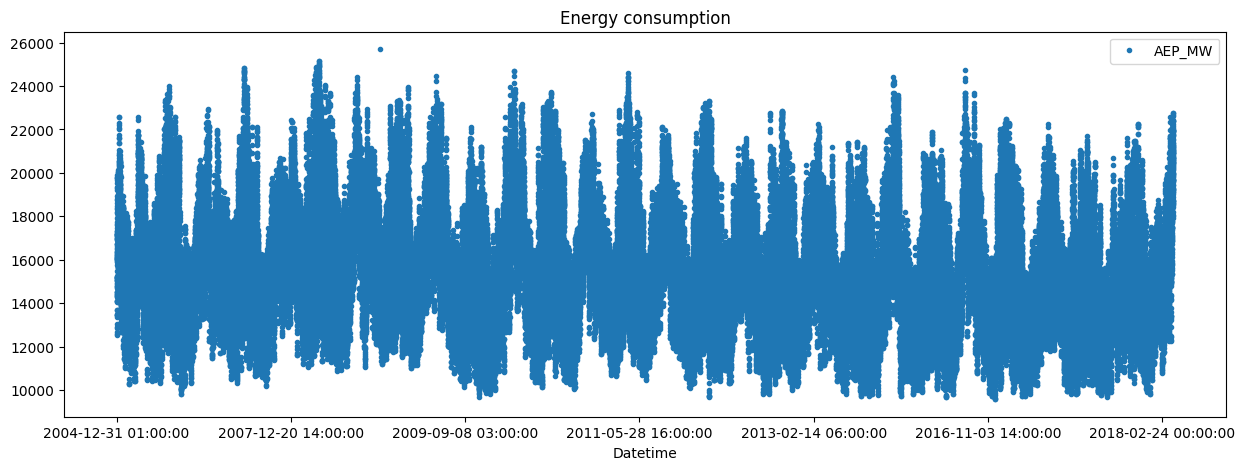

In [ ]:
# Plot the data to see how the distribution is
df.plot(style = ".",
        figsize = (15, 5),
        color= colour_pal[0],
        title = "AEP Energy consumption")

In [ ]:
# Check df.index to see what is the dtype of the DateTime;
df.index

Index(['2004-12-31 01:00:00', '2004-12-31 02:00:00', '2004-12-31 03:00:00',
       '2004-12-31 04:00:00', '2004-12-31 05:00:00', '2004-12-31 06:00:00',
       '2004-12-31 07:00:00', '2004-12-31 08:00:00', '2004-12-31 09:00:00',
       '2004-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=121273)

In [ ]:
# Need to change String to DateTime
df.index = pd.to_datetime(df.index)

In [ ]:
# [TODO: train can be Cross Validated for time-series data]

<Axes: xlabel='Datetime'>

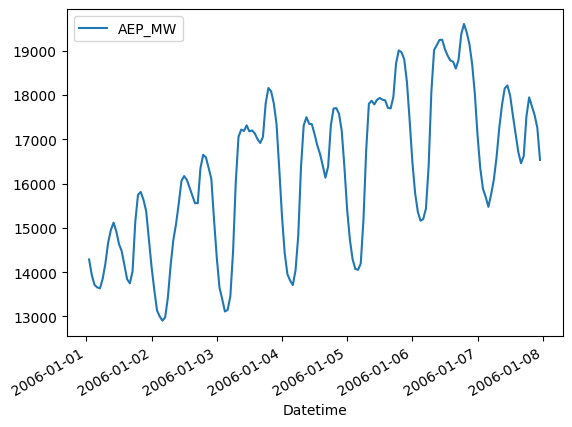

In [ ]:
# Check how the data looks for a week
df.loc[(df.index > '01-01-2006') & (df.index < '01-08-2006')].plot()

The above plot shows that there are two peaks in a day, possibly morning and evening, valleys at night, and different usage in weekends or holidays.

In [ ]:
# Create some features
def create_features(df):
  """
  Create time series features based on time series index
  """
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek # Monday as 0
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear
  # We can have quarter as a feature as well
  return df

df = create_features(df)

Text(0.5, 1.0, 'MW by hour')

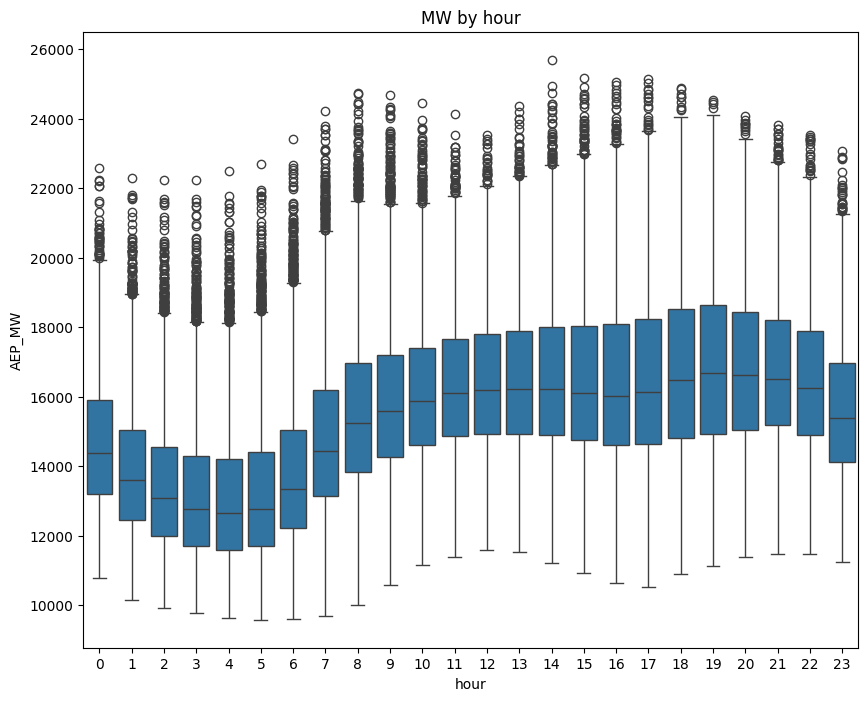

In [ ]:
#Visualise the newly created feature
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y ='AEP_MW')
ax.set_title('MW by hour')

Text(0.5, 1.0, 'MW by hour')

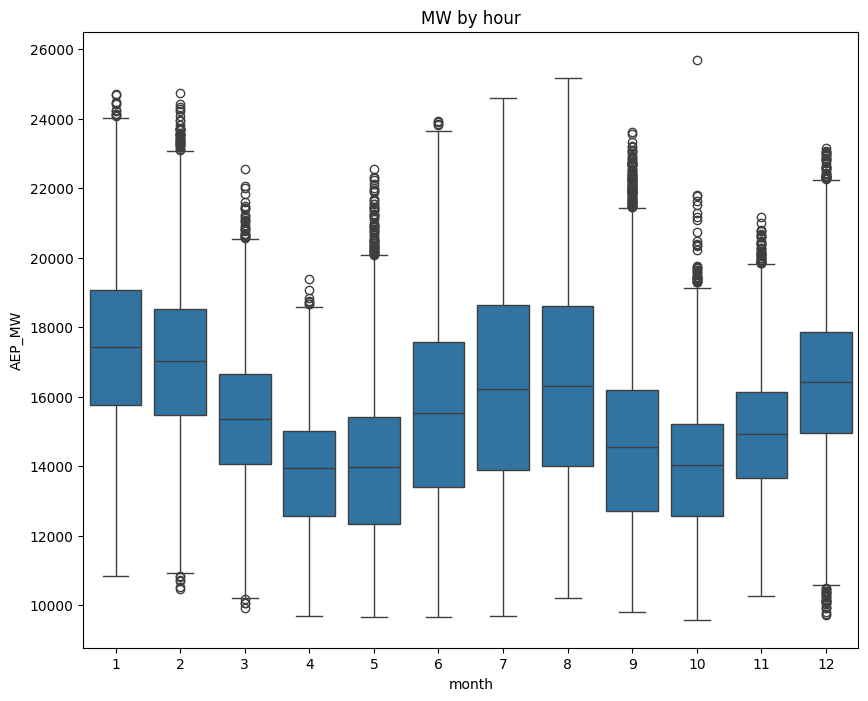

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y ='AEP_MW')
ax.set_title('MW by hour')

In [ ]:
# Now split the data into train/test
# The data before 2015-01-01 is training and including and after 2015-01-01 is
# test data
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= datetime(2015, 1, 1)]

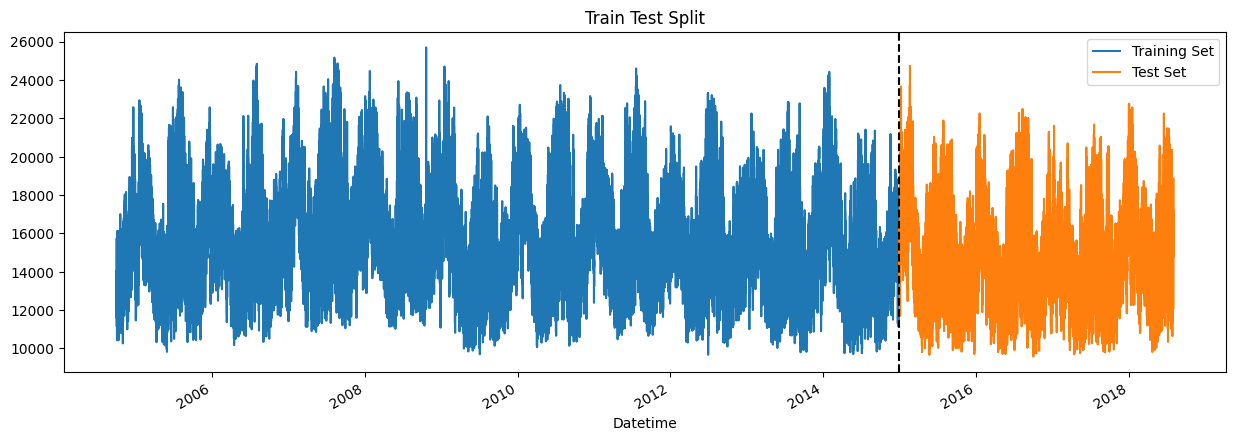

In [ ]:
# Plot the train and test split data
fig, ax = plt.subplots(figsize =(15, 5))
train.plot(ax=ax, label='Training Set', title="Train Test Split")
test.plot(ax=ax, label='Test set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [ ]:
# Create new features for train and test
train = create_features(train)
test = create_features(test)

<ipython-input-51-025361113939>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
<ipython-input-51-025361113939>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek # Monday as 0
<ipython-input-51-025361113939>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [ ]:
train.head()

,AEP_MW,hour,dayofweek,month,year,dayofyear
Datetime,,,,,,
2004-12-31 01:00:00,13478.0,1,4,12,2004,366
2004-12-31 02:00:00,12865.0,2,4,12,2004,366
2004-12-31 03:00:00,12577.0,3,4,12,2004,366
2004-12-31 04:00:00,12517.0,4,4,12,2004,366
2004-12-31 05:00:00,12670.0,5,4,12,2004,366


In [ ]:
test.head()

,AEP_MW,hour,dayofweek,month,year,dayofyear
Datetime,,,,,,
2015-01-01 00:00:00,16375.0,0,3,1,2015,1
2015-12-31 01:00:00,12415.0,1,3,12,2015,365
2015-12-31 02:00:00,12087.0,2,3,12,2015,365
2015-12-31 03:00:00,12010.0,3,3,12,2015,365
2015-12-31 04:00:00,11972.0,4,3,12,2015,365


In [ ]:
# Metrics for the model
from sklearn.metrics import mean_squared_error

In [ ]:
# Set the features column and label
FEATURES = ['hour',	'dayofweek',	'month',	'year', 'dayofyear']
TARGET = 'AEP_MW'

In [ ]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
# Create a XGBoost Regressor
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=True)


[0]	validation_0-rmse:2114.60250	validation_1-rmse:2277.71995
[1]	validation_0-rmse:1833.63034	validation_1-rmse:2038.11906
[2]	validation_0-rmse:1658.94962	validation_1-rmse:1919.68752
[3]	validation_0-rmse:1528.88048	validation_1-rmse:1811.48343
[4]	validation_0-rmse:1454.60428	validation_1-rmse:1775.08904
[5]	validation_0-rmse:1388.08341	validation_1-rmse:1758.59992
[6]	validation_0-rmse:1340.26714	validation_1-rmse:1736.06144
[7]	validation_0-rmse:1308.99020	validation_1-rmse:1721.56501
[8]	validation_0-rmse:1264.80722	validation_1-rmse:1706.92829
[9]	validation_0-rmse:1249.32118	validation_1-rmse:1696.15289
[10]	validation_0-rmse:1205.41126	validation_1-rmse:1698.46525
[11]	validation_0-rmse:1183.75181	validation_1-rmse:1701.02924
[12]	validation_0-rmse:1173.63942	validation_1-rmse:1697.97500


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-rmse:1138.07947	validation_1-rmse:1720.94564
[14]	validation_0-rmse:1132.16964	validation_1-rmse:1718.35402
[15]	validation_0-rmse:1111.47747	validation_1-rmse:1710.76205
[16]	validation_0-rmse:1107.45494	validation_1-rmse:1709.47654
[17]	validation_0-rmse:1088.24502	validation_1-rmse:1737.79534
[18]	validation_0-rmse:1077.31141	validation_1-rmse:1736.37825
[19]	validation_0-rmse:1058.41540	validation_1-rmse:1747.77218
[20]	validation_0-rmse:1051.72747	validation_1-rmse:1744.64271
[21]	validation_0-rmse:1047.16158	validation_1-rmse:1743.65663
[22]	validation_0-rmse:1039.52434	validation_1-rmse:1738.19271
[23]	validation_0-rmse:1033.89222	validation_1-rmse:1758.00119
[24]	validation_0-rmse:1024.51481	validation_1-rmse:1759.90336
[25]	validation_0-rmse:1013.65003	validation_1-rmse:1757.71281
[26]	validation_0-rmse:1004.46627	validation_1-rmse:1749.86517
[27]	validation_0-rmse:998.07089	validation_1-rmse:1748.44315
[28]	validation_0-rmse:986.88873	validation_1-rmse:1768.

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

The above model is overfitting because in the training set the rmse value is going down all the way till the end; however in the test dataset the value is decreasing and then increasing again.

In [ ]:
# Set learning rate
reg = xgb.XGBRegressor(n_estimators=1000,
                       learning_rate = 0.001)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=100)


[0]	validation_0-rmse:2571.77747	validation_1-rmse:2683.12724


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:2418.78537	validation_1-rmse:2543.72673
[200]	validation_0-rmse:2285.21737	validation_1-rmse:2424.24267
[300]	validation_0-rmse:2168.46028	validation_1-rmse:2320.84646
[400]	validation_0-rmse:2066.27063	validation_1-rmse:2231.99828
[500]	validation_0-rmse:1977.35291	validation_1-rmse:2156.44867
[600]	validation_0-rmse:1900.68213	validation_1-rmse:2095.13001
[700]	validation_0-rmse:1832.44385	validation_1-rmse:2040.87265
[800]	validation_0-rmse:1772.78374	validation_1-rmse:1993.65343
[900]	validation_0-rmse:1720.60363	validation_1-rmse:1949.47821
[999]	validation_0-rmse:1674.54889	validation_1-rmse:1911.14625


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
#Feature Importance
fi = pd.DataFrame(reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])

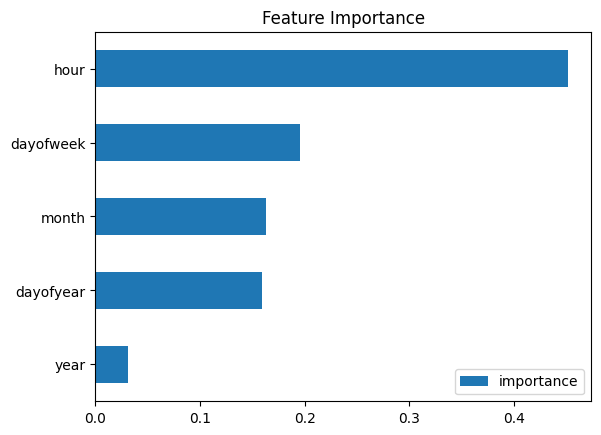

In [ ]:
fi.sort_values('importance').plot(kind='barh', title="Feature Importance")
plt.show()

In [ ]:
# Now Forecasting on the test set
test['prediction'] = reg.predict(X_test)

<ipython-input-75-0fcdc4921c0a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


In [ ]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

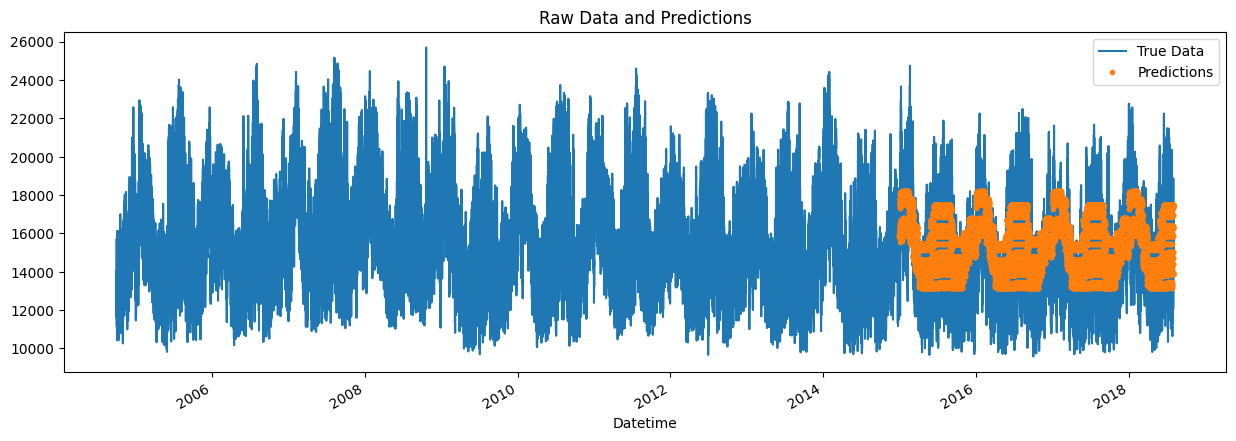

In [ ]:
ax = df[['AEP_MW']].plot(figsize= (15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['True Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

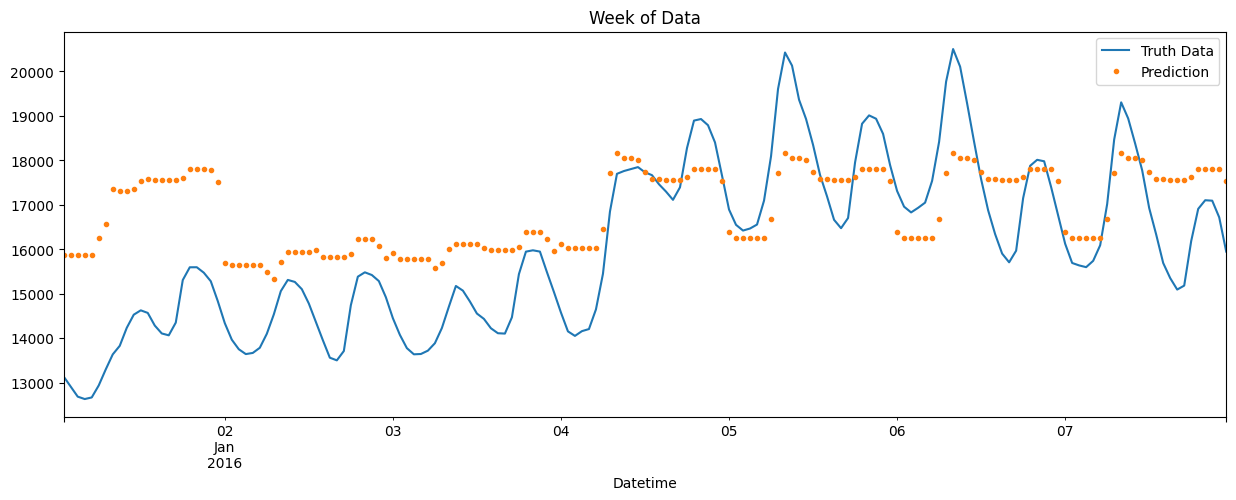

In [ ]:
# Check per week predictions
ax = df.loc[(df.index > '01-01-2016') & (df.index < '01-08-2016')]['AEP_MW'] \
.plot(figsize=(15,5), title = "Week of Data")
df.loc[(df.index > '01-01-2016') & (df.index < '01-08-2016')]['prediction'] \
.plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [ ]:
# Need to do parameter tuning; create new features for weekdays; holidays etc


In [ ]:
# Check the rmse
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1911.15


In [ ]:
# Error calculation
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [ ]:
# Check the best and worst predicted days
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

date
2018-08-03    199.906250
2016-03-04    364.277913
2017-02-03    365.161906
2017-12-17    392.280965
2016-02-26    396.142456
2016-12-22    404.691406
2018-02-07    405.497437
2015-01-16    421.346476
2015-01-12    441.544352
2015-01-23    445.114543
Name: error, dtype: float64

In [ ]:
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2015-02-19    5413.341512
2015-02-20    5269.139038
2015-12-25    4974.974772
2018-01-06    4786.471436
2015-12-24    4571.338135
2015-01-08    4526.346476
2015-02-16    4270.568807
2016-07-04    4127.676229
2018-01-02    4077.786377
2017-01-22    4011.975016
Name: error, dtype: float64

In [ ]:
# Next Steps
#- More robost cross validation
#- Add more features (weather forecast, holidays)
# https://www.youtube.com/watch?v=z3ZnOW-S550&ab_channel=RobMulla